In [1]:
from keras.models import Sequential
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.python.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import tensorflow_addons as tfa

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())

Num GPUs Available:  1
/device:GPU:0


In [3]:
#import splitfolders
#splitfolders.ratio('F:/softcom/dataset/festivals-Splitted/train', output="F:/softcom/dataset/festivals-Splitted/output", seed=1337, ratio=(.85, 0.15)) 

In [4]:
# import pandas as pd

# train_dir = "F:/softcom/dataset/festivals-Splitted - Copy/train"
# img_height,img_width=224,224
# batch_size=100
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   train_dir,
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

# dataset_unbatched = tuple(train_ds.unbatch())
# labels = []
# for (image,label) in dataset_unbatched:
#     labels.append(label.numpy())
# labels = pd.Series(labels)

# # adjustments
# count = labels.value_counts().sort_index()
# count.index = train_ds.class_names

# print(count)

In [5]:
train_dir = "F:/AUST/4.2/8. CSE4238 - Soft Computing Lab/Project/festivals dataset/festivals-Splitted/train"
test_dir = "F:/AUST/4.2/8. CSE4238 - Soft Computing Lab/Project/festivals dataset/festivals-Splitted/test"

# Image size and batch size
img_height,img_width = 224, 224
img_size = (img_height,img_width)
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3175 files belonging to 24 classes.
Using 2540 files for training.
Found 3175 files belonging to 24 classes.
Using 635 files for validation.
Found 804 files belonging to 24 classes.


In [6]:
class_weights_manual = {
    0: 19.3/71,
    1: 19.3/117,
    2: 19.3/90,
    3: 19.3/73,
    4: 19.3/63,
    5: 19.3/251,
    6: 19.3/272,
    7: 19.3/131,
    8: 19.3/204,
    9: 19.3/121,
    10: 19.3/193,
    11: 19.3/112,
    12: 19.3/71,
    13: 19.3/64,
    14: 19.3/98,
    15: 19.3/98,
    16: 19.3/90,
    17: 19.3/39,
    18: 19.3/50,
    19: 19.3/107,
    20: 19.3/62,
    21: 19.3/127,
    22: 19.3/64,
    23: 19.3/119
}

In [7]:
model = Sequential()


pretrained_model= tf.keras.applications.ConvNeXtBase(include_top=False,
                   input_shape=(img_height,img_width,3),
                   weights='imagenet')
for layer in pretrained_model.layers[:int(len(pretrained_model.layers)*.75)]:   
       layer.trainable=False

model.add(pretrained_model)
# Add GlobalAveragePooling layer
model.add(GlobalAveragePooling2D())
# [:int(len(pretrained_model.layers)*.75)]
# Add fully connected layer with L2 regularization
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model.add(Dropout(0.2))
model.add(Dense(24, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.1)))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 7, 7, 1024)        87566464  
                                                                 
 module_wrapper (ModuleWrapp  (None, 1024)             0         
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 512)              524800    
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 512)              0         
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 256)              131328    
 pper)                                                  

In [8]:
checkpoint_filepath = 'F:/AUST/4.2/8. CSE4238 - Soft Computing Lab/Project/Project Last Run/convnextbaseckpt.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,patience=5, min_lr=0.00001)

In [9]:
# optimizers = [
#     tf.keras.optimizers.Adam(learning_rate=1e-5),
#     tf.keras.optimizers.Adam(learning_rate=1e-3)
# ]
# optimizers_and_layers = [(optimizers[0:3], model.layers[0]), (optimizers[1], model.layers[3:])]
# optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              sample_weight_mode='temporal'
             )
epochs=50

In [10]:
from datetime import datetime
start = datetime.now()
history = model.fit(
  train_ds,
  validation_data=val_ds,
  verbose="auto",
  callbacks=[model_checkpoint_callback,lr_callback],
  epochs=epochs, #class_weight=class_weights_manual
)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/50
159/159 [==============================] - 85s 425ms/step - loss: 1.4588 - accuracy: 0.6138 - val_loss: 0.9792 - val_accuracy: 0.7118 - lr: 0.0010
Epoch 2/50
159/159 [==============================] - 62s 386ms/step - loss: 0.5768 - accuracy: 0.8421 - val_loss: 0.7821 - val_accuracy: 0.8016 - lr: 0.0010
Epoch 3/50
159/159 [==============================] - 62s 388ms/step - loss: 0.3210 - accuracy: 0.9134 - val_loss: 1.0068 - val_accuracy: 0.7969 - lr: 0.0010
Epoch 4/50
159/159 [==============================] - 62s 389ms/step - loss: 0.2354 - accuracy: 0.9346 - val_loss: 0.8010 - val_accuracy: 0.8016 - lr: 0.0010
Epoch 5/50
159/159 [==============================] - 63s 392ms/step - loss: 0.2130 - accuracy: 0.9480 - val_loss: 0.9724 - val_accuracy: 0.7811 - lr: 0.0010
Epoch 6/50
159/159 [==============================] - 62s 390ms/step - loss: 0.1735 - accuracy: 0.9567 - val_loss: 1.1050 - val_accuracy: 0.7717 - lr: 0.0010
Epoch 7/50
159/159 [==============================] 

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["accuracy", "val accuracy"], loc="upper left")
    plt.show()

In [ ]:
plot_hist(history)

In [16]:
result=model.evaluate(
    test_ds,
    batch_size=batch_size,
    verbose="auto"
)
#8769

51/51 [==============================] - 12s 225ms/step - loss: 0.7073 - accuracy: 0.8769


In [15]:
#save

# model.save_weights('F:/AUST/4.2/8. CSE4238 - Soft Computing Lab/Project/Project Last Run/convnextbase.h5', overwrite=True, save_format=None, options=None)

#load

# model.load_weights('F:/AUST/4.2/8. CSE4238 - Soft Computing Lab/Project/Project Last Run/convnextbaseckpt.h5', skip_mismatch=False, by_name=False, options=None)

# model.load_weights('F:/AUST/4.2/8. CSE4238 - Soft Computing Lab/Project/Project Last Run/convnextbase.h5', skip_mismatch=False, by_name=False, options=None)


1/1 [==============================] - 0s 99ms/step


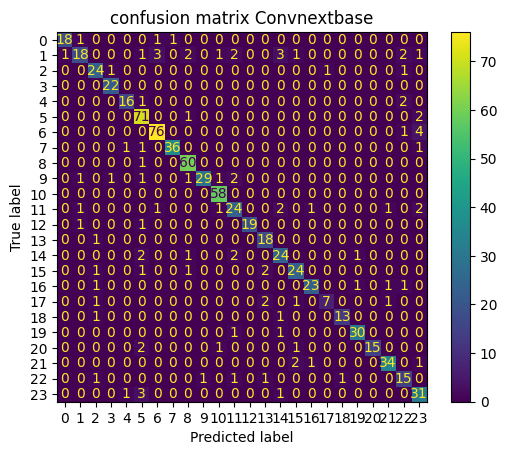

accuracy:  87.68656716417911
precision: [0.94736842 0.81818182 0.8        0.91666667 0.88888889 0.83529412
 0.9382716  0.97297297 0.90909091 0.96666667 0.93548387 0.75
 1.         0.7826087  0.75       0.82758621 0.92       0.875
 0.92857143 0.9375     1.         0.91891892 0.68181818 0.73809524]
recall: [0.85714286 0.51428571 0.88888889 1.         0.84210526 0.95945946
 0.9382716  0.92307692 0.98360656 0.80555556 1.         0.72727273
 0.9047619  0.94736842 0.8        0.82758621 0.85185185 0.58333333
 0.86666667 0.9375     0.78947368 0.89473684 0.75       0.86111111]
fscore: [0.9        0.63157895 0.84210526 0.95652174 0.86486486 0.89308176
 0.9382716  0.94736842 0.94488189 0.87878788 0.96666667 0.73846154
 0.95       0.85714286 0.77419355 0.82758621 0.88461538 0.7
 0.89655172 0.9375     0.88235294 0.90666667 0.71428571 0.79487179]
support: [21 35 27 22 19 74 81 39 61 36 58 33 21 19 30 29 27 12 15 32 19 38 20 36]


In [17]:
y_true = []
y_pred = []
for x,y in test_ds:
  y= tf.argmax(y,axis=1)
  y_true.append(y)
  y_pred.append(tf.argmax(model.predict(x),axis = 1))
  
y_pred = tf.concat(y_pred, axis=0)
y_true = tf.concat(y_true, axis=0)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("confusion matrix Convnextbase")
plt.show()
precision, recall, fscore, support = score(y_true, y_pred)

print("accuracy: ",100*accuracy_score(y_true, y_pred))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

In [ ]:
SIZE = 224  #Resize images
import glob
import os
import shap
import cv2
#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

for directory_path in glob.glob("F:/AUST/4.2/8. CSE4238 - Soft Computing Lab/Project/festivals dataset/festivals-Splitted/test/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)
X = train_images

import json

# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# load pre-trained model and choose two images to explain
# model = ResNet50(weights="imagenet")

# image = cv2.imread('F:/softcom/dataset/festivals-Splitted - Copy/test/holi/holi-005.jpeg')
# image = cv2.resize(image, (224, 224))
# image = np.expand_dims(image, axis=0)
def f(X):
    tmp = X.copy()
#     preprocess_input(tmp)
    return ensemble_model(tmp)

# X = image
# X, y = shap.datasets.imagenet50()

# load the ImageNet class names as a vectorized mapping function from ids to names
# url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
# with open(shap.datasets.cache(url)) as file:
#     class_names = [v[1] for v in json.load(file).values()]

class_names = train_ds.class_names

# define a masker that is used to mask out partitions of the input image, this one uses a blurred background
masker = shap.maskers.Image("inpaint_telea", (224,224,3))

# By default the Partition explainer is used for all  partition explainer
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we use 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    X[60:64], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:4]
)
shap.image_plot(shap_values)